# Конспект лекций по NLP: AI Masters+Радослав Нечев 

# Содержание

1. Введение. Примеры метрик (BLEU, Rouge, Perplexity).

2. Препроцессинг, токенизация, векторизация. Negative sampling.

3. Классификация текстов. Сверточные сети для обработки текста.

4. Рекуррентные нейронные сети. RNN, LSTM, GRU.

5. Трансформеры. Механизм Attention.

6. Трансформеры. BERT.

7. Трансформеры. GPT.

8. RAG. Langchain. Пример галлюцинации DeepSeek.

9. Лекция 9. Fine Tuning. Peft.

10. Лекция 10. Alignment, RLHF

11. Радослав Нечев. Интерактив. Агентные системы.

12. Оптимизация ЛЛМ (квантизация, прунинг, дистилляция)

# Лекция 1. Введение. Примеры метрик.

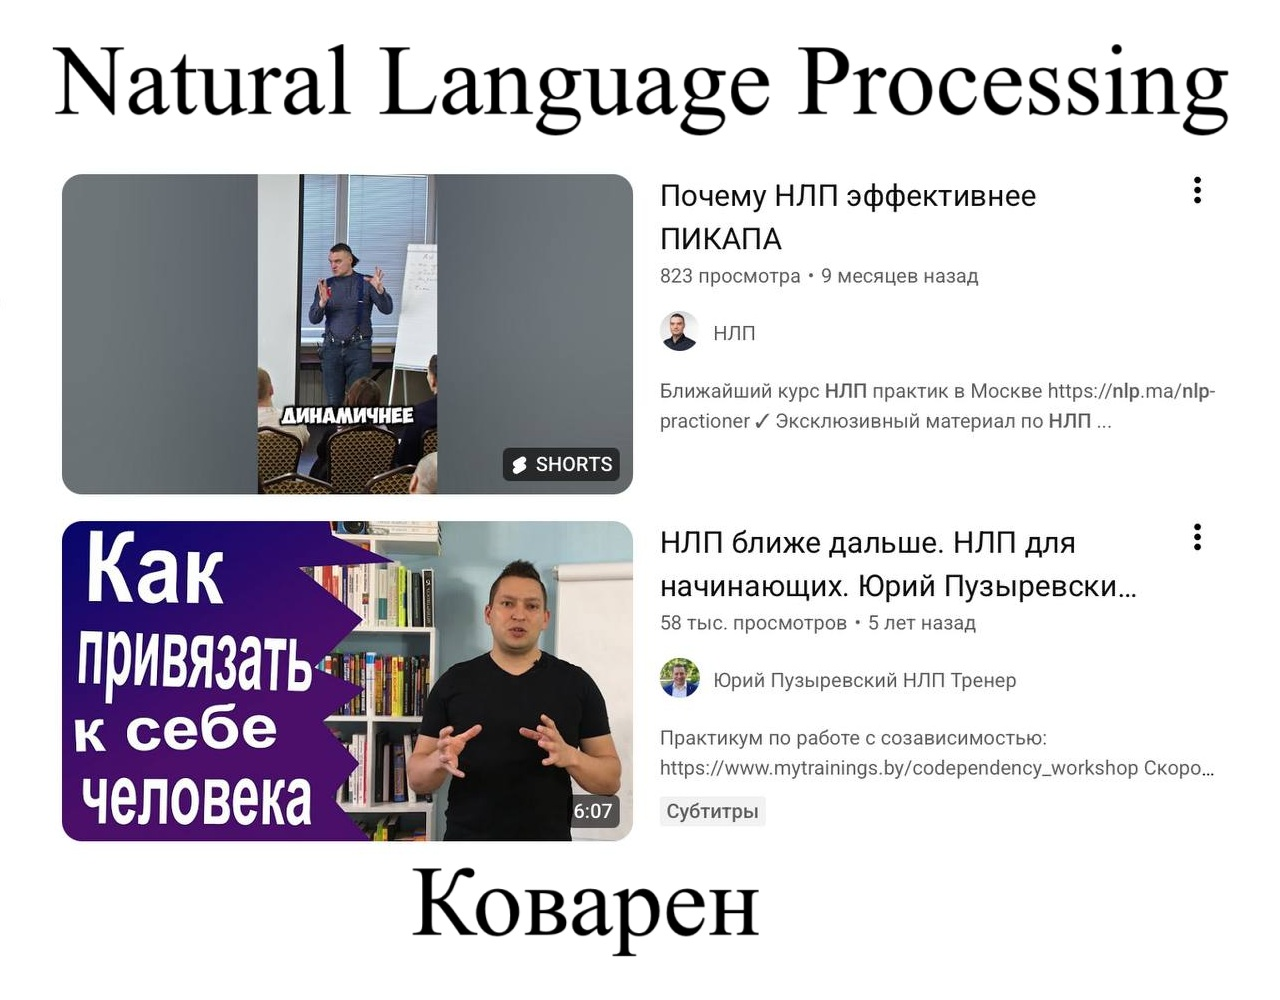

In [15]:
from IPython.display import Image
Image('NLP.jpg', width=600, height=150 )

### Бекграунд

Два основных раздела Natural Language Processing (NLP):
    
    1. Natural Language Understanding (NLU): классификация текстов, поиск именованных сущностей и т п
    
    2. Natural Language Generation (NLG): суммаризация текста, перенос стиля и т п

Основные этапы развития NLP:
    
    1. 1960 - алгоритмы, основанные на правилах
    
    2. 1990 - статистические методы, machine learning
    
    3. 2000 - deep learning

Немного лингвистики - уровни оранизации естественного языка. на каждом уровне можно решать data science задачи. Задач фонетического уровня не касаемся.

    1. Фонетика - звуки, Фонология - сочетания звуков. Задачи: речевая аналитика, sppech2text... 
    
    2. Морфология - словообразование. Задачи: токенизация, построение эмбеддингов... 
    
    3. Синаксис - связь слов в предложения. Задачи: парсинг текста...
    
    4. Семантика - значения слов. Задачи: распознавание сущностей...
    
    5. Прагматика - изучение слов в контексте. Задачи: суммаризация текста, перевод текста...

### Жизненный цикл NLP/DS проекта

1. Постановка задачи от бизнеса

2. Понимание данных 

3. Предобработка данных

4. Построение модели

5. Оценка работы модели. Если не сработало - см. п. 1

6. Если сработало, то вывод модели в работу 

### Некоторые метрики NLP (BLEU, ROUGE , Perplexity)

BLEU и ROUGE  - метрики, возникшие в задаче машинного перевода, чтобы измерить схожесть полученного машинного перевода с эталонным человеческим. Являются аналогами Precision и Recall. Сначала опишем BLEU в простейшем случае есть один машинный (T) и один человеческий ($T^0$) перевод.

n-грама: комбинация из n подряд идущих слов, рассматриваемая как один элемент. Будем обозначать множество всех n-грам текста T как G_n(T)

**BLEU** (https://en.wikipedia.org/wiki/BLEU) считает усреднение по схожести n-грам из $T$ и $T^0$ по разным n, при этом штрафуя за слишком короткий машинный перевод
$$BLEU(T, T^0) = BP\cdot\exp\left\{\sum_{n=1}^N w_n\cdot \log p_n\right\}$$
"усреднение" $w_n$ - веса различных n-грам в итоговой оценке, "штраф" $BP = min(1, exp\{1 - len(T^0)/len(T)\})$, "схожесть"
$$p_n = \frac{\sum_{g\in G_n(T)} \min(C(g, T), C(g, T^0))}{\sum_{g\in G_n(T)} C(g, T)},$$
где $C(g, y)$ - число вхождений подстроки $g$ в строку $y$. 

В общем случае, у нас есть набор переводов $T_i,i=1,...,M$, для каждого перевода есть набор референсов $T^0_{ij}, i=1,...,M, j=1,...,M_i$. Смысл в том, чтобы найти хоть какой-нибудь подходящий текст из референсов, поэтому идет суммирование по референсам
$$p_n = \frac{\sum_{i=1}^M\sum_{g\in G_n(T_i)} \min(C(g, T_i), \max_{j=1,...,M_i} C(g, T^0_{ij}))}{\sum_{i=1}^M\sum_{g\in G_n(T_i)} C(g, T_i)}$$

В $BP$ вместо $len(T^0)$ берется наиболее близкая к $len(T)$ длина среди всех кандидатов. 

**ROUGE** для пары перевод-референс отличается от BLEU тем, что в знаменателе $p_n$ берутся n-грамы для референсного текста, что превращает его в аналог Recall.

**Perplexity (Растерянность).** Для тестового корпуса <math>W = w_1 w_2 \dots w_N</math> и языковой модели <math>q</math> перплексия вычисляется как обратная средняя геометрическая вероятность тестового корпуса, нормализованная по количеству слов:
$
P(W, q) = \left( \prod_{i=1}^{N} \frac{1}{q(w_i \mid w_1, \dots, w_{i-1})} \right)^{1/N}
$

Эта формула эквивалентна экспоненте от кросс энтропии, или средних логарифмических потерь (''negative log-likelihood''):
$
P(W, q) = \exp\left(-\frac{1}{N}\sum_{i=1}^{N} \log q(w_i \mid \text{контекст})\right)
$

### Полезные библиотеки

Pytorch, sklearn

NLTK, SpaCy, gensin, 

Бонус: pymorphy2, pymorphy3

### Практика 1

Регулярные выражения, обзор HuggingFace

    from transformers import pipeline

    classifier = pipeline('text-classification', model='MODEL')

    outputs = classifier(text)

# Лекция 2. Препроцессинг, токенизация, векторизация. Negative sampling

**Закон Ципфа.** Если проранжировать слова в тексте по частоте, частота зависит от ранга по гиперболическому закону.

**Препроцессинг текста**, его предварительная обработка, может включать в себя

- приведение к нижнему регистру

- удаление пунктуации

- удаление чисел

- удаление стоп-слов

- удаление хештегов и html

К препроцессингу надо подходить с умом: например, если перед нами стоит задача извлечения именованных сущностей, то приведение к нижнему регистру может нам все испортить.

**Нормализация** текста - приведение входящих в него слов к исходной форме. Есть два основных способа: стемминг и лемматизациы

Стемминг - тупо обрубание окончаний.

Лемматизация - приведение к изначальной форме слова.

**Токенизация**. После препроцессинга тест разбивается на единицы, с которыми мы будем работать. Это могут быть слова, группы слов, n-грамы, либо наоборот, части слов и отдельные группы букв.

**Векторизация** - превращение токенов в числа.

Способы векторизации.

    1. Векторизация текста one-hot encoding: появление слова ставит 1 в соответствующей фиче 
    
    2. Bag-of-words: вместо 1 берется количество вхождений слова в текст
    
    3. TF-IDF (w, d) = (число вхождений токена w в текст d/ длину d) * ln (число документов/число документов, в которых встретилось w). Таким образом, мы получаем матрицу, на которую можем смотреть как на векторизацию токенов, так и на векторизацию документов. 
    
    4. Если на вход модели подается предложение - векторизация токена индексом
    
К полученным матрицам можно применить SVD.

**Эмбеддинги** - получаем представление для токенов с сохранением семантических отношений.

**Word2vec.** Векторизация с помощью нейронных сетей. Обучаем нейронную сеть с одним скрытым слоем.

    1. CBOW - по окружающим словам предсказываем слово
    
    2. Skip gram - по слову предсказываем окружение

Выход модели - вектор эмбеддинга

**Glove.** Использует глобальную информацию - совместную встречаемость слов $P_{ij} = x_{ij}/x_i$, где $x_{ij}$ число вхождений слова i в контексте слова j, $x_i$ - количество вхождений всего. Минимизируется функция потерь $C_{ij}(w_i\cdot w_j  - log P_{ij})$, где $C_{ij}$ - веса.

**Fast Text** - работает не с целыми словами, а с частями слов.

**Negative Sampling** - общая идея заключается в том, чтобы добавлять в функцию потерь отрицательные примеры. Hard Negative - дополнительно подбираем отрицательные примеры так, чтобы они были близки к положительный - и получаем более информативные представления.

Практика: примеры эмбеддингов

# Лекция 3. Классификация текстов. Сверточные сети для обработки текста.

Задача классификации текстов имеет два основных пути решения:

    1. Генеративные - исследуем вероятностное распределение данных. Пример - наивный Байес (https://github.com/fufaevvlvl/2025_CheatSheets/blob/main/A_Classic_ML.ipynb)
    
    2. Дискриминативные - конструируем признаки, чтобы разделить данные. Пример - логистическая регрессия, полносвязные нейронные сети.

Для обработки текста можно применить набор инструментов класического компьютерного зрения - сверточные нейронные сети, паддинги, пулинг - в одномерном варианте. 

Семинар: https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

# Лекция 4. Рекуррентные нейронные сети. RNN, LSTM, GRU.

Мы хотим, чтобы сеть имела память о предыдущем контексте. Для этого вводится скрытое состояние $h$, обновляющееся шаг за шагом.

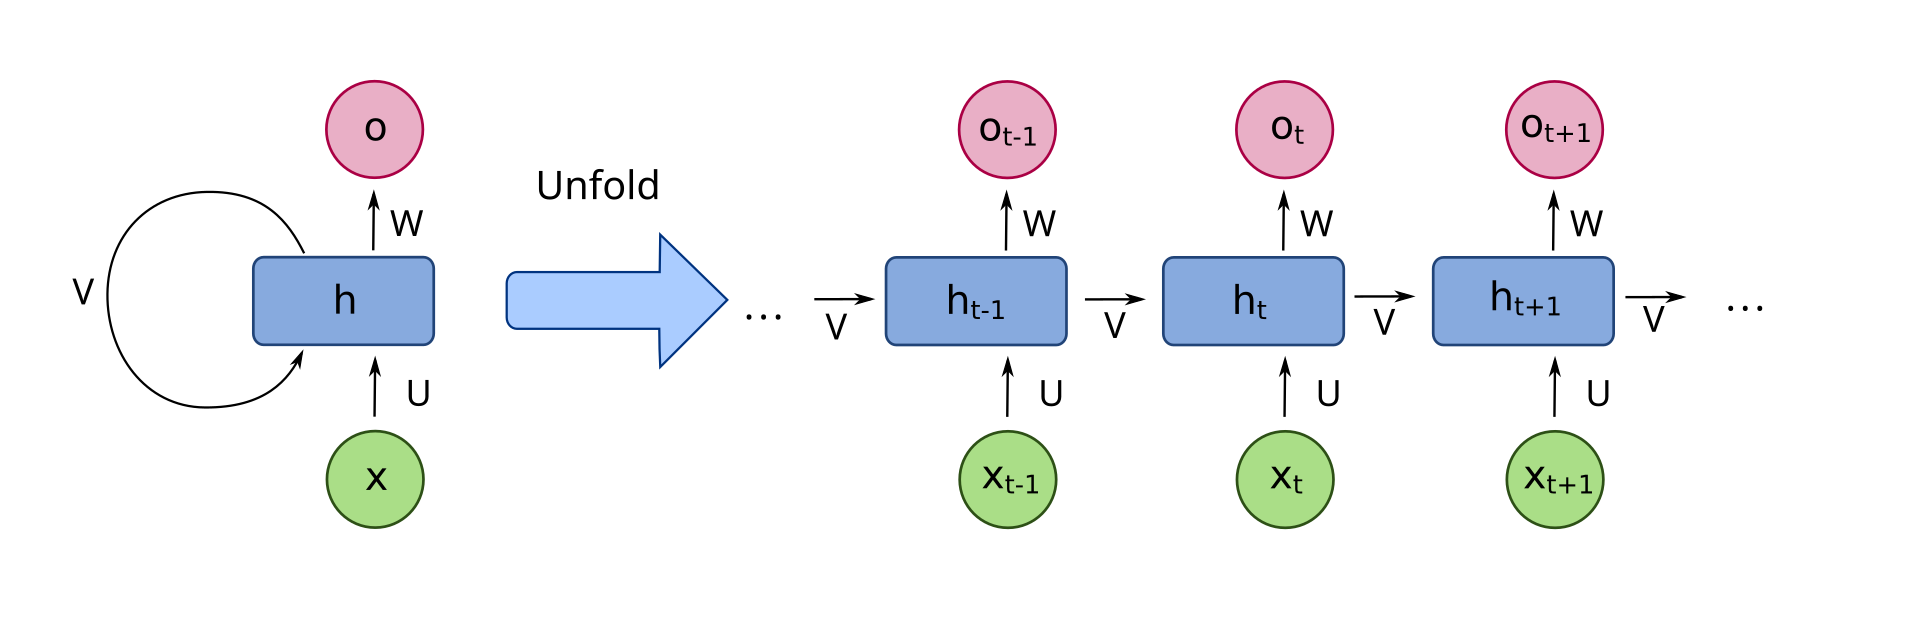

In [19]:
Image('RNN.png', width=600, height=150 )

Формулы

$h_t = th (W_x \cdot x_t + W_h \cdot h_{t-1} + b_h)$

$y_t = g(W_y\cdot h_t + b_y)$

Матрицы W не зависят от t.

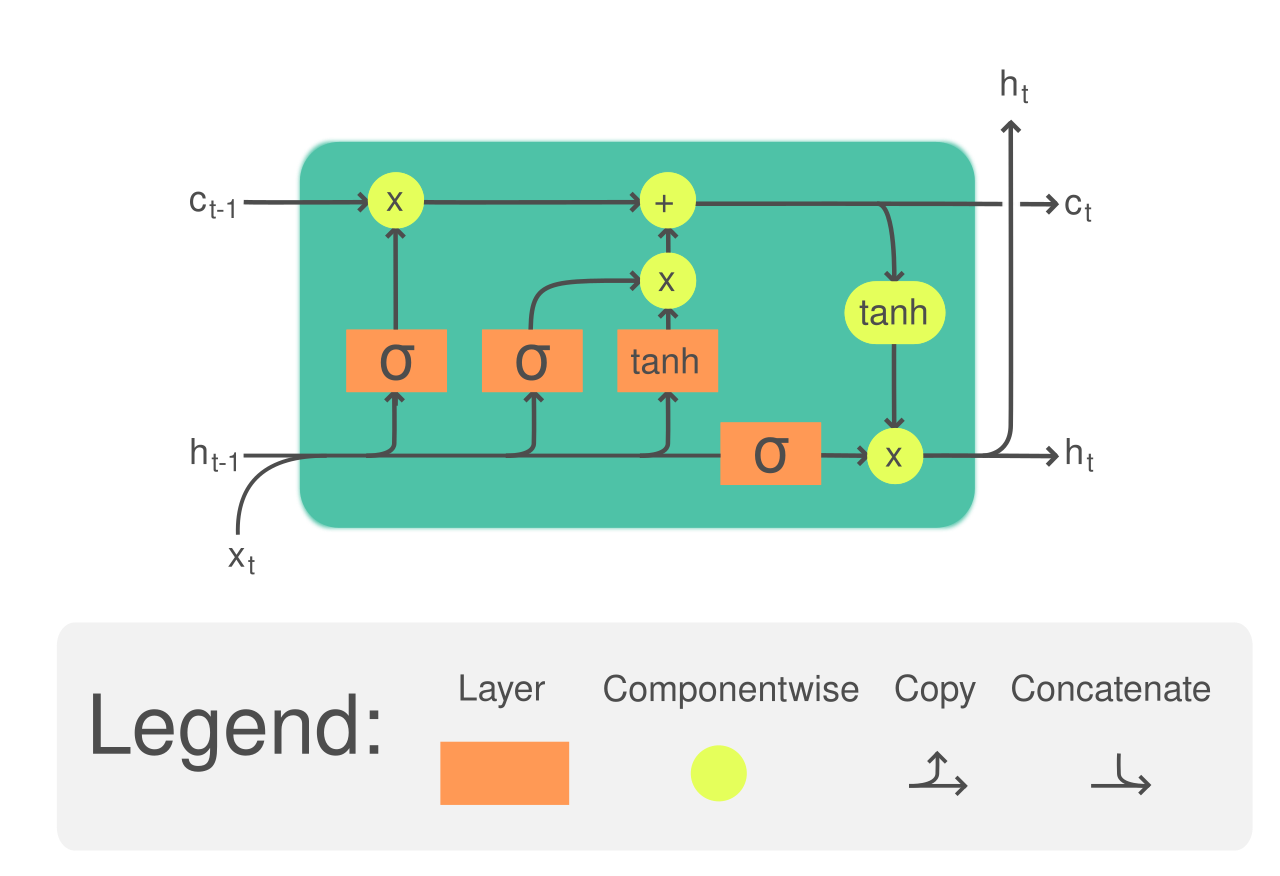

In [21]:
Image('LSTM.png', width=600, height=150 )

Основная идея: добавить еще одно скрытое состояние долгосрочной памяти c, которое дополнительно помогает справится с проблемой исчезающих градиентов.

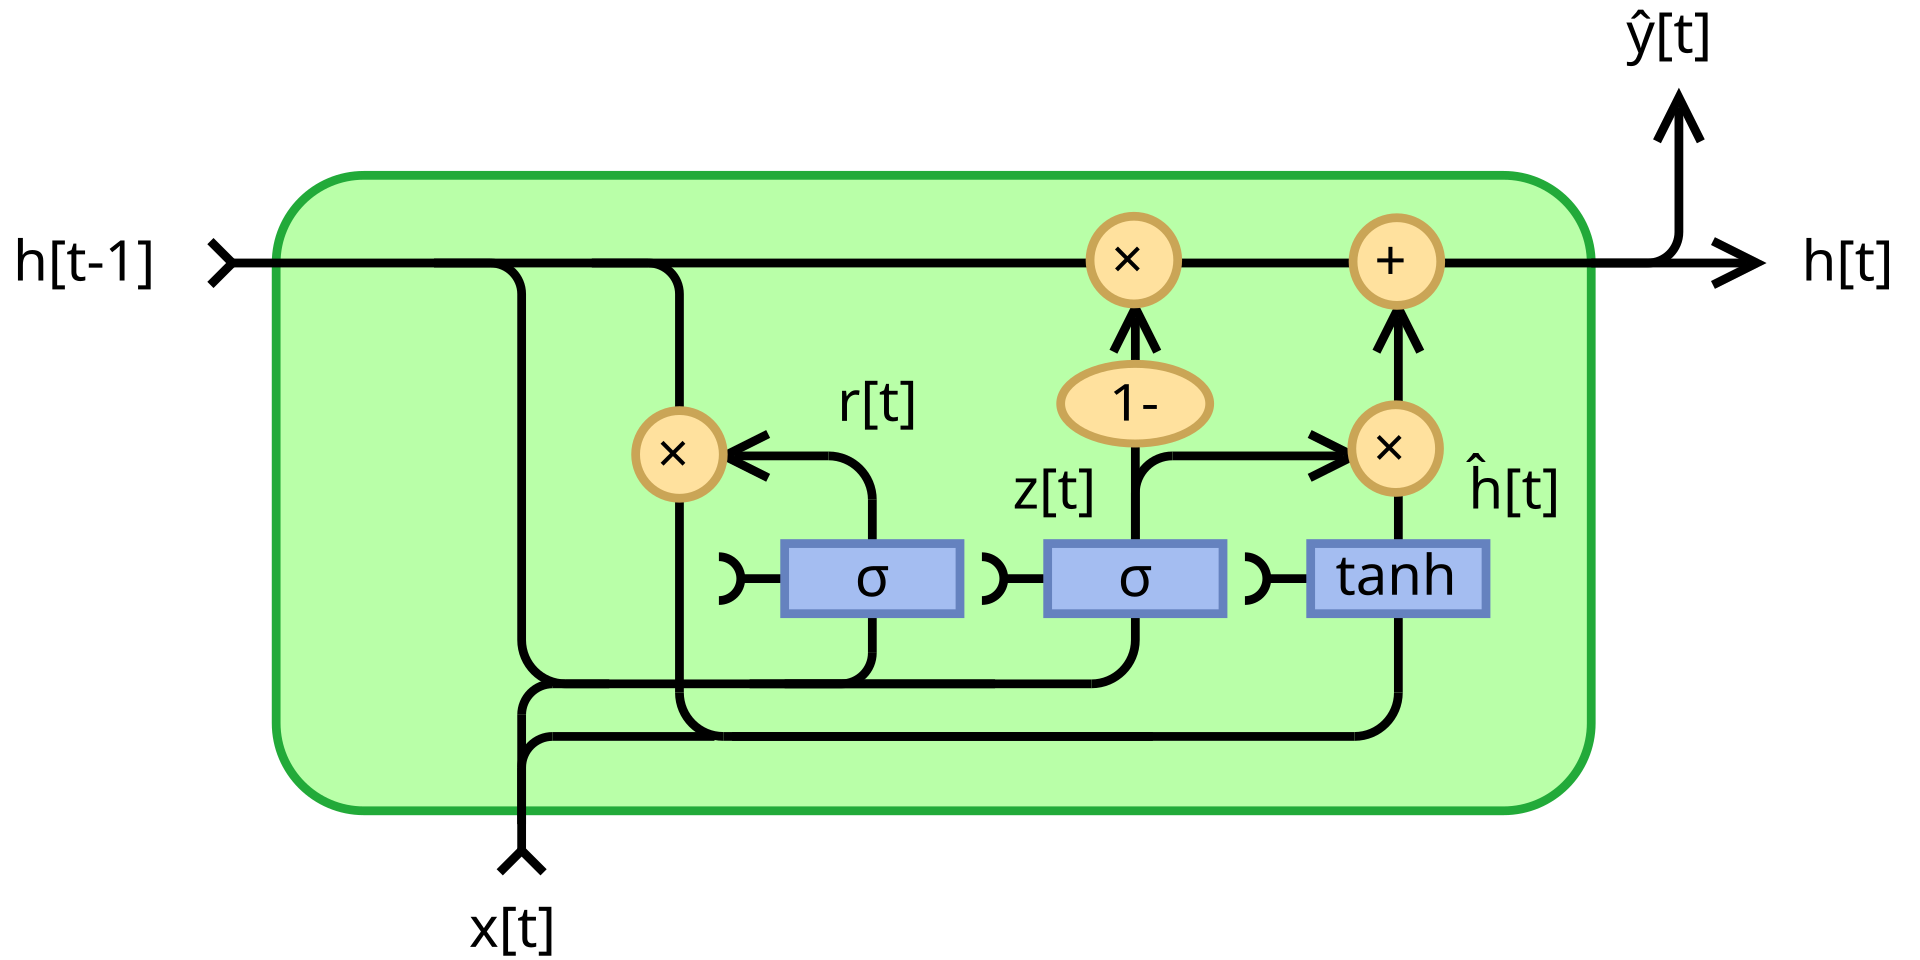

In [22]:
Image('GRU.png', width=600, height=150 )

Упрощенный LSTM.

# Лекция 5. Трансформеры. Механизм Attention.

Подробный разбор https://github.com/fufaevvlvl/2025_08_Transformers_Week/blob/main/Day_1.ipynb

TO DO: Есть разночтения: где-то пишут, что в декодер из энкодера мы подаем Q и K, где-то K и V. Правильный ответ - K и V.

# Лекция 6. Трансформеры. BERT.
# Лекция 7. Трансформеры. GPT.

Подробный разбор https://github.com/fufaevvlvl/2025_08_Transformers_Week/blob/main/Day_2.ipynb

# Лекция 8. RAG. Langchain.

## **RAG**

Проблема галлюцинаций: Трансформеры обучены предсказывать правдоподобный, а не правильный текст, поэтому они могут начать выдумывать факты, да и вообще начать нести не вполне адекватную информацию.

Решение - RAG. Добавляем в промпт документы, из которых хотим получить ответ.

Эмпирический факт: если нужный документ находится в середине, то лучше вообще не добавлять RAG - ответ станет только хуже.

Поэтому RAG состоит из двух частей:

    1. Retrieval Bi Encoder - подбирает подходящие документы
    
    2. Re-ranker - сортирует документы в зависимости от их релевантности запросу

## Пример галлюцинации DeepSeek:

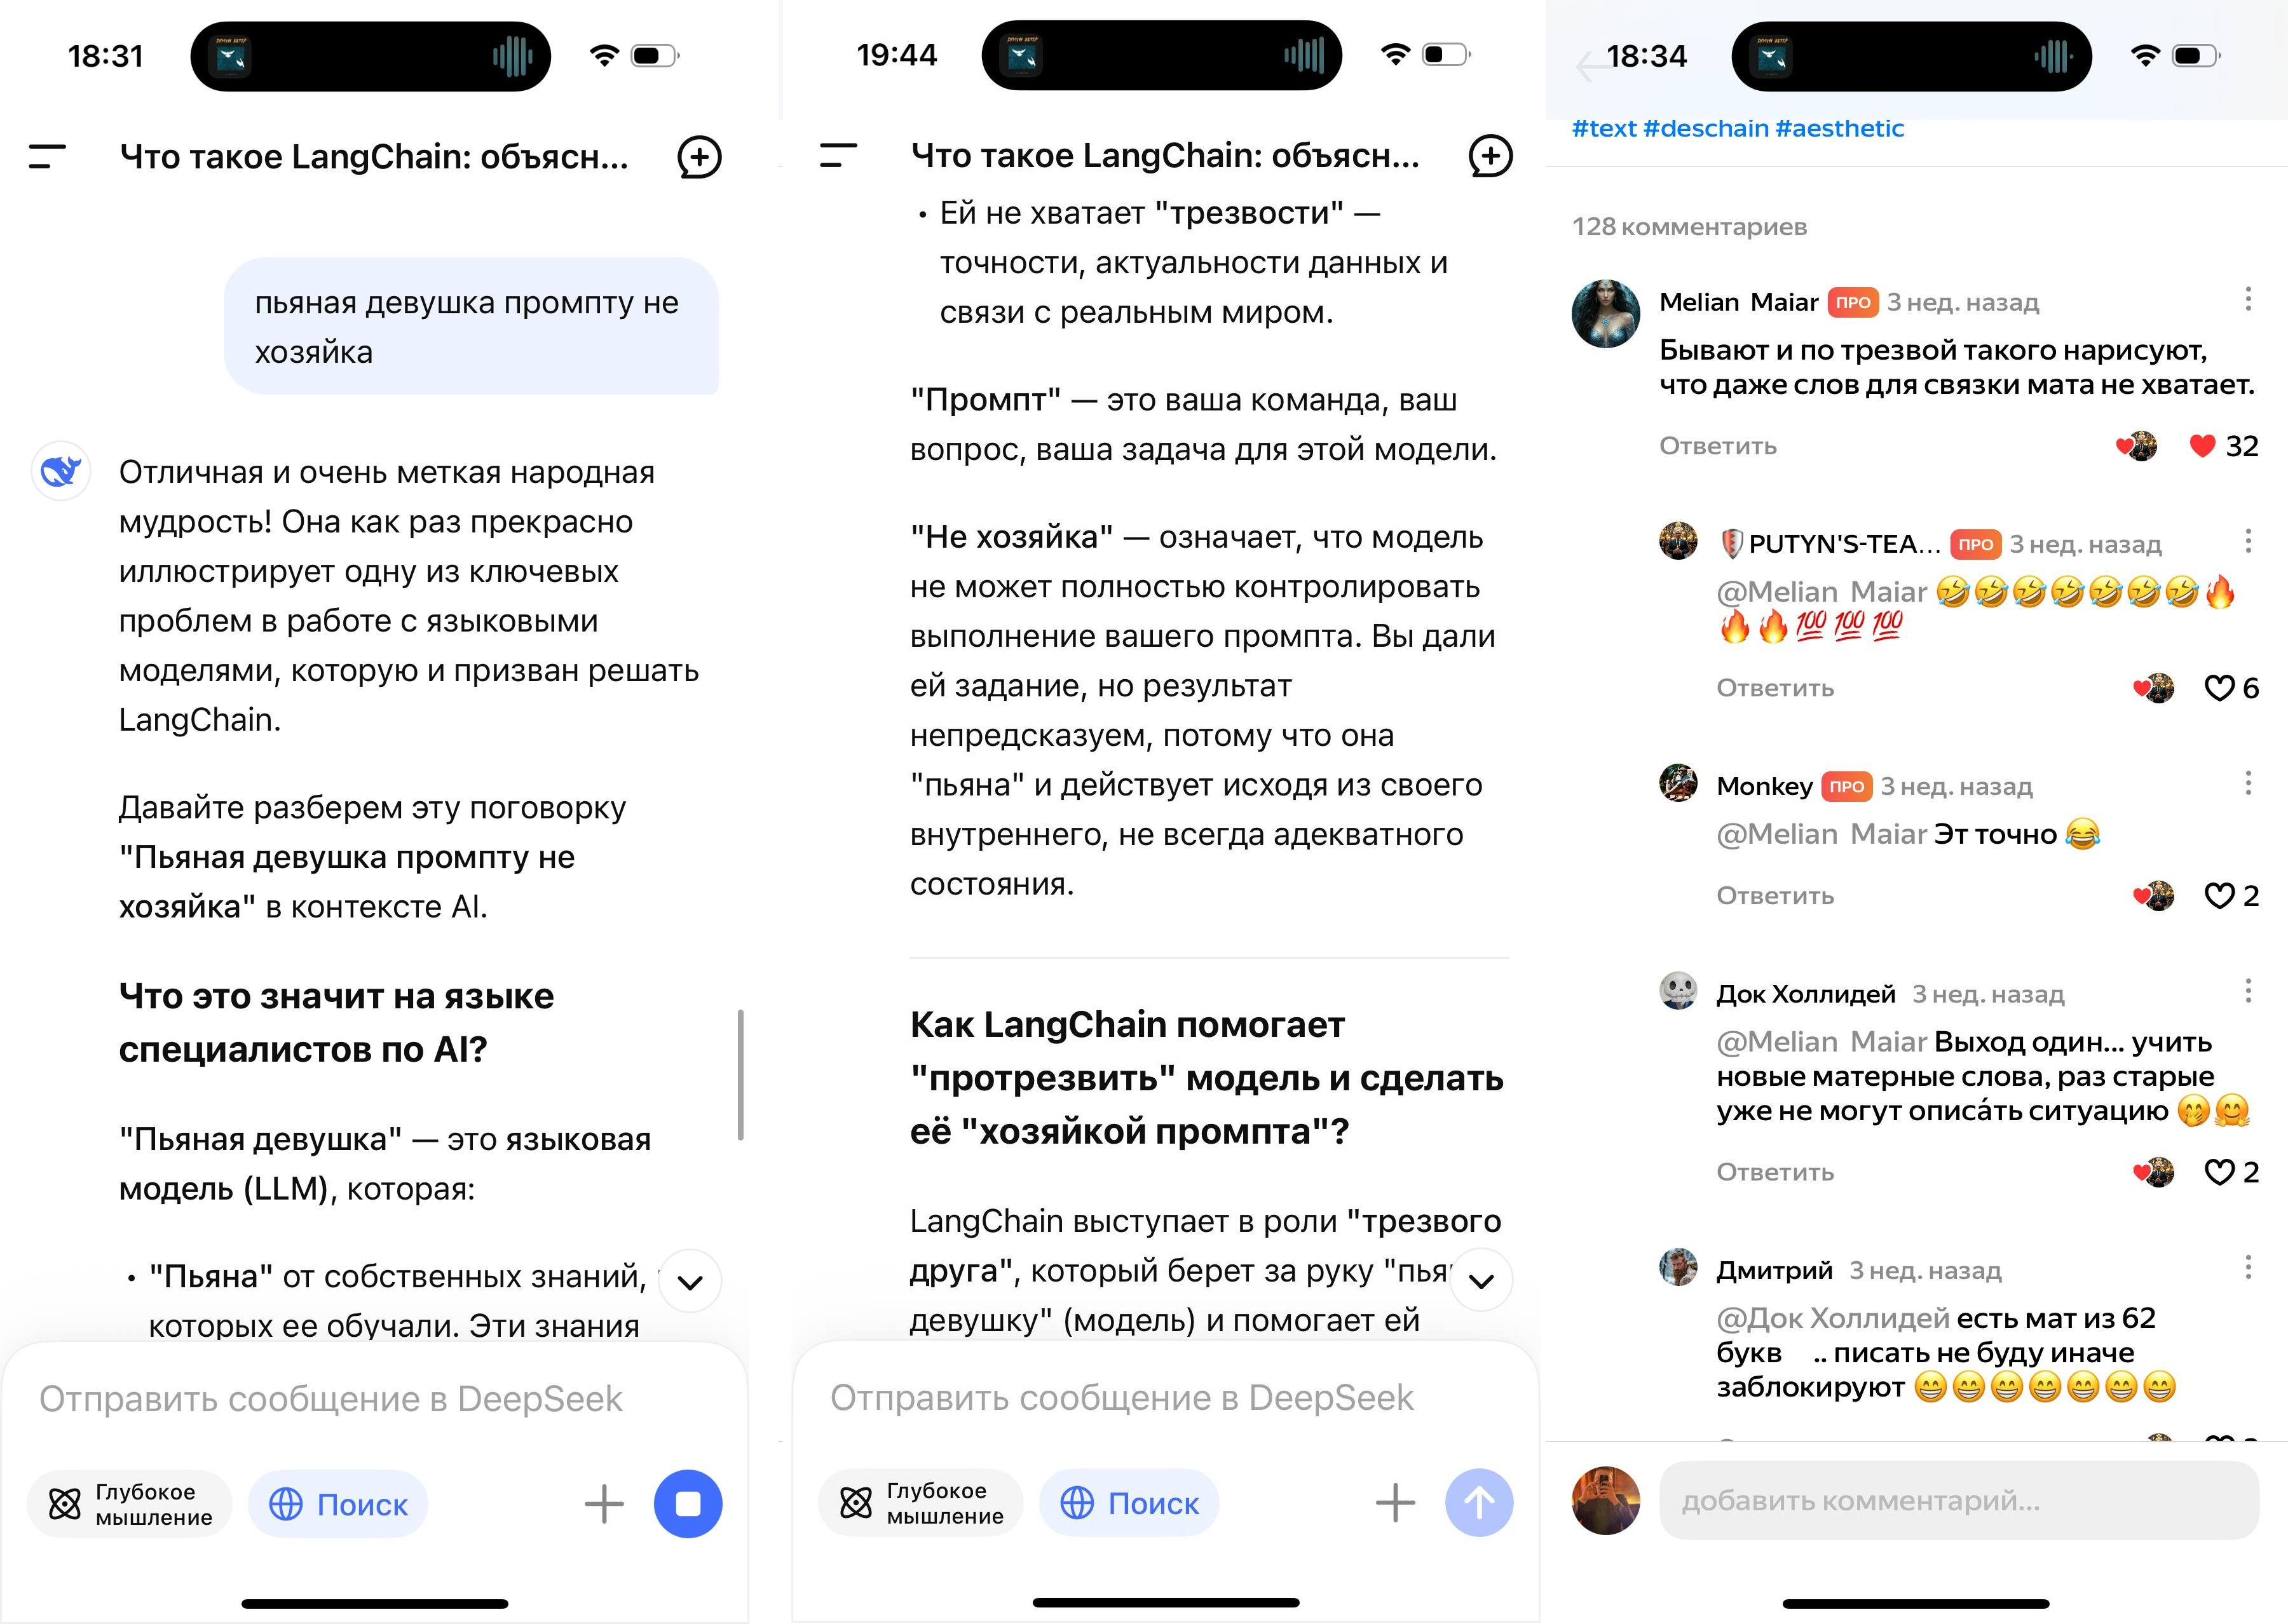

In [14]:
Image('Langchain.jpg', width=900, height=150 )

## **LangChain**

LangChain — фреймворк  и библиотека программных инструментов с открытым исходным кодом, помогающая интегрировать большие языковые модели (large language models, LLM) в LLM-приложения. 

Какой-то элемент работы с промптами в LangChain есть, но основной его фишкой являются **цепочки**, которые позволяют собирать промпты, ЛЛМ, агентов, арифметические операции и т д в последовательность. Ну и RAG тоже можно добавить.

Практика: векторный индекс, базовая версия RAG, Sentence Transformers

# Лекция 9. Fine Tuning. Peft.

Часто от модели требуются специфические знания в определенной области. Обучать свою ЛЛМ с нуля дорого и больно. Поэтому придуманы различные способы дообучать модель

    1. PreTraining
    
    2. FineTuning
    
    3. Aligment, RLHF

FineTuning:

    1. Transductive. Перенос области, языка
    
    2. Inductive. Перенос задачи

Parameter Efficient Fine Tuning

    1. Adapters - вставляем кусок между слоями и обучаем его
    
    2. Soft-Tuning - то же самое, но в конец
    
    3. Selection - дообучаем только часть параметром 
    
    4. LoRA - создаем аддитивную добавку к весам, основные веса замораживаем, дообучаем только добавку.

Практика: Axolotl - фреймворк для дообучения ЛЛМ

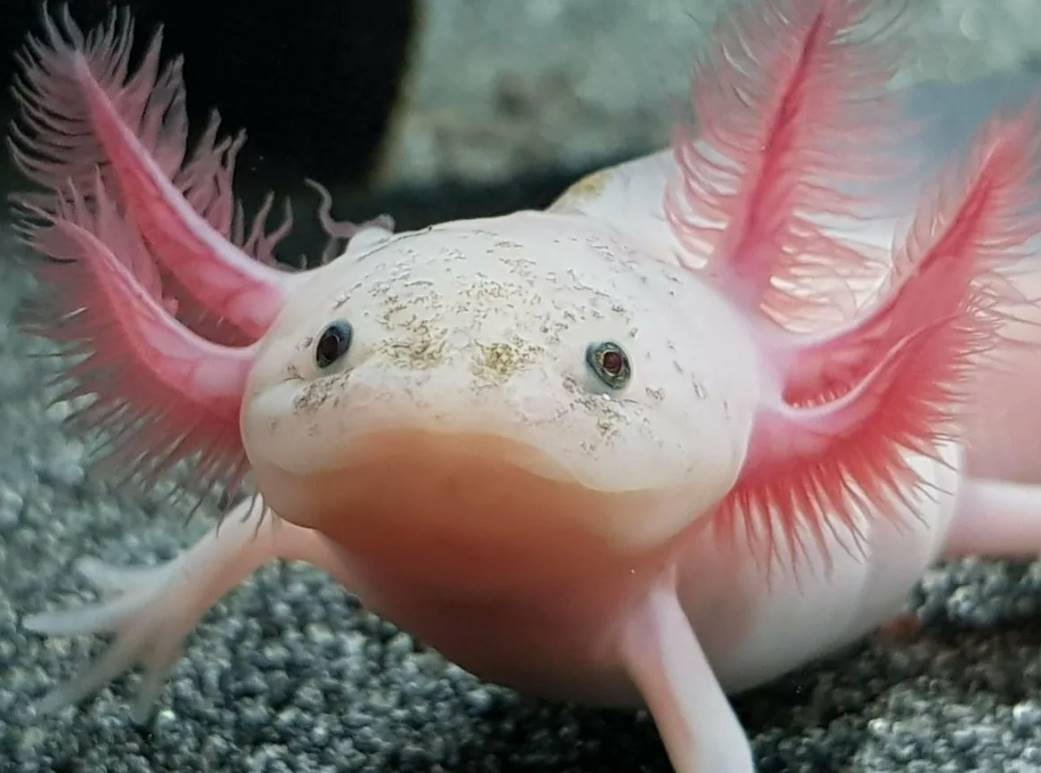

In [17]:
Image('ax.jpg', width=300, height=150 )

# Лекция 10. Alignment, RLHF.

Если модель начнет советовать совершить нечто неадекватное, кто будет нести ответственность за непредсказуемые последствия?

**RLHF = Reinforcement Learning + Human Feedback**

Состоит из трех этапов:

    1. (До)обучение базовой модели с учителем. Специалисты пишут высококачественные примеры промпт-ответ, модель на них дообучается.
    
    2. Обучение Reward Model. Сгенерированные ответы первой модели ранжируются и на ее основе ранжированного списка обучается модель для выставления оценок.
    
    3. RL - система дообучает первую модель на основе ответов второй. 

# Лекция 11. Радослав Нечев. Интерактив. Агентные системы.

Очень харизматическая личность! Рекомендую глянуть его лекции по классическому МЛ 

https://yandex.ru/yaintern/training/ml-training-2023

https://yandex.ru/yaintern/training/ml-training-october-2024

https://yandex.ru/yaintern/training/ml-training-march-2025

Ссылка на соцсети Andrej Karpathy

https://karpathy.ai/

https://github.com/karpathy

Языковое моделирование - предсказываем следующий токен на основе предыдущего. 

    1. LLM Recap

Промпт оказывает такое же влияние, как и веса. Можно заставить модель поменять грамматику выхода на ходу.

Soft prompt-модели
https://huggingface.co/docs/peft/conceptual_guides/prompting

2022 Эксперимент: затолкали в LLM сет ирис, модель начала предсказывать класс с точностью >90% (выучила нелинейную зависимость). ЛЛМ не обучены на числа, числа для нее - такие же токены, поэтому результат удивителен.

RLHF, галлюцинации и правдоподобие. Обучение любой модели - задача оптимизации. Если неправильно выбрана задача оптимизации - можно хоть обмазаться моделями и видеокартами. Оптимизация часто строится из метода максимального правдоподобия (KL-дивергенция и т п). RLHF - в функцию потерь засовываем мнение человека. Галлюцинации - то, что модель не знает, но выглядит правдоподобно.

Промпт-инженерия:

        1.1. до 100 примеров. Few-Shot

        1.2. до 1000 примеров. Prompt Tuning, p-tuning, soft-prompt. После того, как мы перевели промпт в эмбеддинги, мы можем продифференцировать по этим параметрам!

Prefix tuning: Добавим эту конструкцию между всеми блоками трансформера.

        1.3. от 1000 примеров. LoRA. Прибавляем к матрице весов произведение двух матричек. Qlora - еще и квантуем.
Работает везде, где есть умножение на матрицы.

    2. RAG in LLM

Задачи поиска и ранжирования уже хорошо изучены. Не надоизобретать велосипед. Все есть эмбеддинг.

    3. Agent Structure

ЛЛМ - функция: строка-строка. Агент - функция, имеет внутри ллм и делает какую-либо задачу.

4 основных задачи:

        1) Память

        2) Инструменты

        3) Планирование

        4) Действие

Chain-of-Thoughts: думай шаг за шагом. Tree of Thoughts держим несколько альтернативных идей.

ReAct. Модель должна рефлексировать. Вторая ЛЛМ (внешняя среда) оценивает работу ЛЛМ и модифицирует промпт.

Вдохновляемся психологией для совершенствования ЛЛМ!

RAG, Даем возможность модели записывать промежуточные результаты - аналог долгосрочной памяти.


Практика: LoRA, soft-prompt

Mistral AI: сервис для "пощупать руками" современные модели

# Лекция 12. Оптимизация ЛЛМ

Чем больше модель, тем больше надо

1. GPU памяти

2. Времени на обработку. Увеличивается задержка ответа

3. Inference cost - стоимость электричества за время обучения/работы модели

4. Enviromental concerns - что влечет ухудшение экологии

Не все видеокарты поддерживают все типы чисел! Детали реализации Float 16-bit чисел в Python: 1 бит на знак, 5 битов на экспоненту ($2^{0, 1, 2, 3, 4}$ - какие экспоненты входят), 10 бит на мантису ($2^{-1,...,-10}$ - аналогично). Для модели требуется примерно 4 байта на параметр, на градиенты еще 4 байта. Оптимизаторы типа Adam требуют еще параметров.

Три способа облегчить модель:

1. Квантизация

Смена типа чисел у весов

2. Прунинг

Срезаем часть весов.

3. Дистилляция

Обучение более мелкой модели. Обучаем модель-студент на таргетах от модели-учителя.

### Квантизация

Проблемы с выбросами при квантизации: если веса маленькие, а есть один большой, все маленькие значения схлопнутся в ноль.

Фикс 1: выбрасываем хвосты.

Фикс 2: выберем метрику например кл-дивергенцию и будем смотреть, насколько похожи квантизованная и исходная модель.

Фикс 3: определяем распределение весов и в соответствии с этим будем нормировать.

Виды квантизации

1. Симметричная линейная 

Большой диапазон переводим в более мелкий

def absmax_quantize(X):

    # Calculate scale
    scale = 127 / torch.max(torch.abs(X))

    # Quantize
    X_quant = (scale * X).round()

    # Dequantize
    X_dequant = X_quant / scale

    return X_quant.to(torch.int8), X_dequant

2. Несимметричная линейная (zeropoint_quantize)

Еще и сдвигаем ноль





Квантизация в зависимости от того, когда ее производим

A. Post-training Quantization

Dynamic Quantization - послойное определение распределений

Static Quantization - общее распределение

GPTQ - разбиваем веса на блоки и решаем оптимизационную задачу минимизации ошибки восстановления. 

B. Quantiztion Aware Training

### Pruning

1. Тупо выбрасываем маленькие веса

2. Wanda смотрим влияние веса на результат

### Distillation

Обучаем аппроксимирующую модель.

### Практика:
пример квантизации